# Sequential fingerspelling data

Dataset: https://www.kaggle.com/competitions/asl-fingerspelling

This notebook contains a brief statistical analysis of the above dataset and provides an example of how to use it for training a model.

# Dependencies

In [14]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [15]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [16]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [17]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
cv2.setRNGSeed(seed)

# Load data

In [18]:
PATH_KAGGLE_DS = "kaggle_dataset"
dataset_df = pd.read_csv(os.path.join(PATH_KAGGLE_DS, "train.csv")) #supplemental_metadata.csv
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head()

Full train dataset shape is (67208, 5)


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [19]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from random row
    sequence_id, file_id, phrase, path = dataset_df.sample(n=1).iloc[0][['sequence_id', 'file_id', 'phrase', 'path']]
    print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")
    
    # Fetch data from parquet file
    sample_sequence_df = pq.read_table(f"kaggle_dataset/{path}",
        filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
    
    return sample_sequence_df

In [20]:
random_sequence()

sequence_id: 2092898448, file_id: 1365275733, phrase: supremasi
Full sequence dataset shape is (108, 1630)


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
2092898448,0,0.623855,0.610464,0.614304,0.596522,0.609076,0.608341,0.607539,0.515737,0.605947,...,-0.140485,-0.141052,-0.072821,-0.139993,-0.145696,-0.133185,-0.096161,-0.144027,-0.145883,-0.135363
2092898448,1,0.624134,0.609649,0.613573,0.595848,0.608312,0.607684,0.607128,0.516476,0.605604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092898448,2,0.631341,0.613402,0.616369,0.599359,0.612159,0.611357,0.610212,0.516377,0.608558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092898448,3,0.626971,0.612870,0.616600,0.598649,0.611506,0.610725,0.609646,0.516957,0.607850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092898448,4,0.627229,0.611280,0.615245,0.597200,0.609816,0.609101,0.608255,0.514717,0.606045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092898448,103,0.603225,0.586083,0.590808,0.573038,0.584663,0.584261,0.584554,0.494749,0.583048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2092898448,104,0.591547,0.576739,0.581011,0.564109,0.575511,0.575295,0.576012,0.485083,0.574731,...,-0.146184,-0.150250,-0.071829,-0.136625,-0.143066,-0.131498,-0.088870,-0.133292,-0.135379,-0.124557
2092898448,105,0.574263,0.559131,0.562731,0.546987,0.558067,0.557915,0.558571,0.468462,0.557559,...,-0.173396,-0.176274,-0.101973,-0.172430,-0.176990,-0.165518,-0.123777,-0.166268,-0.164383,-0.153589


# Animation preview

In [25]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [38]:
video = produce_video_from_seq(random_sequence())
create_animation(video)

sequence_id: 338298843, file_id: 1557244878, phrase: 695 natl forest develop road
Full sequence dataset shape is (222, 1630)


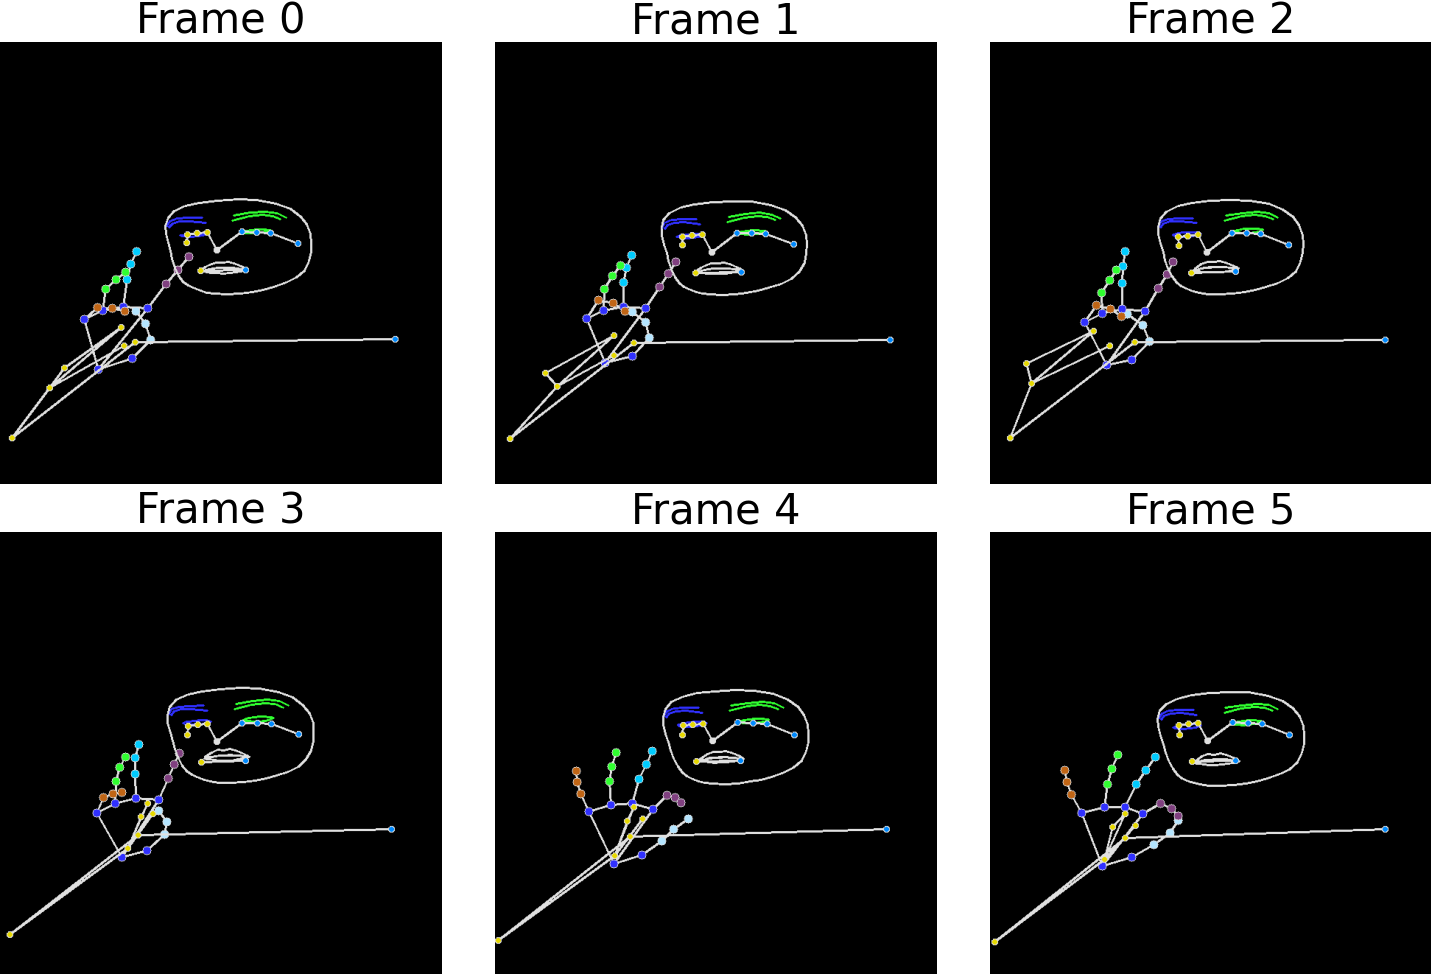

In [59]:
n = 6
fig, axs = plt.subplots(2, n//2, figsize=(15,10))  # Adjust size and number of subplots as necessary
axs = axs.ravel()
for i, j in zip(range(0, n*5, 2), range(n)):
    axs[j].imshow(video[i])
    axs[j].set_title(f"Frame {j}", fontsize=30)
    axs[j].axis('off')
plt.tight_layout()
plt.savefig('animation.png', dpi=300, transparent=True)  # High resolution
plt.show()

# Statistics

In [62]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.savefig(f'{title}.png', dpi=300)  # High resolution
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50, 75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

## Length of phrases

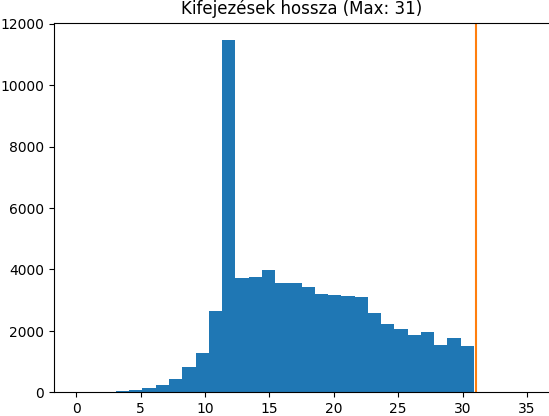

25th percentile: 12.0
50th percentile: 17.0
75th percentile: 22.0
80th percentile: 23.0
90th percentile: 27.0


In [63]:
phrase_lengths = []
def gather_lenghts(phrase: str):
    phrase_lengths.append(len(phrase))
    return phrase
dataset_df.phrase.apply(gather_lenghts)

lengths_hist(phrase_lengths, "Kifejezések hossza", 35)
calc_percentiles(phrase_lengths)

## Length of sequences

  0%|          | 0/68 [00:00<?, ?it/s]

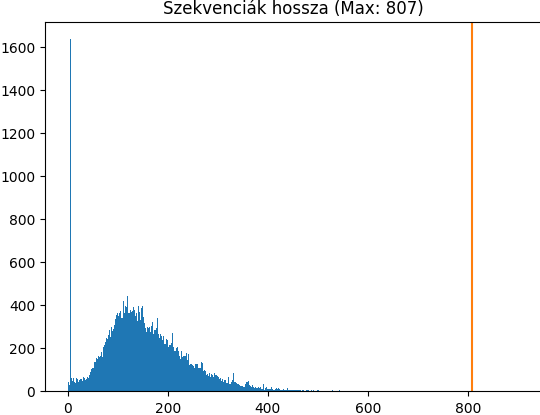

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [65]:
seq_lengths = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    seq_lengths.extend(list(pq.read_table(pq_file,columns=['sequence_id']).to_pandas().index.to_series().value_counts()))

lengths_hist(seq_lengths, "Szekvenciák hossza", 900)

calc_percentiles(seq_lengths)

What's interesting to note is that there are many cases where the sequences are only a few frames long. This is normal if the phrase associated with the sequence has a short length. From the animation preview, it is clear that in many frames the detailed hand landmarks are not available.

To cater to the above a heuristic condition is applied:
    - Calculate how many frames the dominant hand is visible on
    - Require at least two frames per character in the associated phrase

  0%|          | 0/68 [00:00<?, ?it/s]

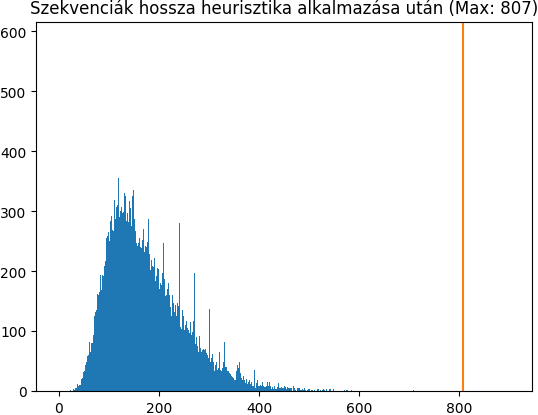

25th percentile: 104.0
50th percentile: 148.0
75th percentile: 207.0
80th percentile: 223.0
90th percentile: 270.0


In [67]:
# Hand column headers
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)]

# Feature column headers
feature_columns = X + Y + Z

# Index of the right and left hand in feature column headers
rhand_idx = [i for i, col in enumerate(feature_columns)  if "right" in col]
lhand_idx = [i for i, col in enumerate(feature_columns)  if  "left" in col]

seq_lengths_filtered = []
for file_path in tqdm(dataset_df.path.unique()):
    pq_file = f"kaggle_dataset/{file_path}"
    # For some reason the next two lines cannot be placed in a single line as it results in an error
    # If anyone figures out what can cause that contact me:)
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + feature_columns).to_pandas()
    parquet_numpy = parquet_df.to_numpy()
    
    parts = file_path.split('/')
    last_part = parts[-1]
    number_string = last_part.split('.')[0]
    file_id = int(number_string)
    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    
    for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
        # Fetch sequence data
        frames = parquet_numpy[parquet_df.index == seq_id]
        
        # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
        r_nonan = np.sum(np.sum(np.isnan(frames[:, rhand_idx]), axis = 1) == 0)
        l_nonan = np.sum(np.sum(np.isnan(frames[:, lhand_idx]), axis = 1) == 0)
        
        # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
        num_of_visible = max(r_nonan, l_nonan)
        
        # Heuristic condition
        if 2*len(phrase) < num_of_visible:
            seq_lengths_filtered.append(len(frames))

lengths_hist(seq_lengths_filtered, "Szekvenciák hossza heurisztika alkalmazása után", 900)
calc_percentiles(seq_lengths)

The models input will be the padded sequences. It's an iteresting optimization task as cutting off at lower lengths wastes data, but saves computation time, and easier to learn for the model.

# Save to TFRecords

This step speeds up the training process dramatically.

In American Sign Language (ASL), finger-spelling is a method used to spell out words by forming individual letters with one's fingers. It's commonly used for proper nouns, technical terms, or any word for which there isn't a specific sign.

Facial expressions, on the other hand, are an integral part of ASL and play a crucial role in conveying meaning, tone, and emotion. In ASL, they can change the meaning of a sign, indicate a question, show intensity, and more. However, when it comes to finger-spelling specifically, facial gestures don't contribute to the actual letters being spelled. That said, facial expressions might still accompany finger-spelling to provide context, emotion, or emphasis.

For example, if someone is finger-spelling the name of a person they're frustrated with, their facial expression might show that frustration, even if the expression isn't altering the letters themselves. The facial expression provides the emotional context, while the finger-spelling provides specific information.

In summary, while facial gestures don't change the letters or meaning of finger-spelled words, they can provide additional context and emotional nuance.

This very dataset is available on kaggle: https://www.kaggle.com/datasets/marcelldancs/asl-fingerspelling-tdk

In [24]:
# Collecting the required data's index in the mediapipe model.

# These points represent the hands, elbows, and shoulders.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]

# Facial information isn't necessary, but the nose will serve as a midpoint for normalizing the data, as it is usually located in the middle of the frame.
FPOSE = [0] # Nose as midpoint

# X,Y,Z column header names.
POSE = LPOSE + RPOSE + FPOSE
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

# Feature vectors are the ones used for training.
FEATURE_COLUMNS = X + Y + Z

# Collecting the indices of certain important/distinct sets of features.
# This can be beneficial during the preprocessing step.
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 0] # Nose

In [25]:
def save_tfrecords_to(folder: str):
    # Loop through each file_id
    for file_path in tqdm(dataset_df.path.unique()):
        # Parquet file name
        pq_file = os.path.join(PATH_KAGGLE_DS, file_path)

        # Gather file_id
        parts = file_path.split('/')
        last_part = parts[-1]
        number_string = last_part.split('.')[0]
        file_id = int(number_string)
        
        # Filter train.csv and fetch entries only for the relevant file_id
        file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
        
        # Fetch the parquet file
        parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
        parquet_numpy = parquet_df.to_numpy()

        # File name for the updated data
        tf_file = os.path.join(folder, f"{file_id}.tfrecord")
        
        # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            # Loop through each sequence in file.
            for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
                # Fetch sequence data
                frames = parquet_numpy[parquet_df.index == seq_id]

                # Calculate the number of rows that only have NaN values -> on how many frames each hand is fully visible
                r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
                l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
                # Number of frames where the dominant hand is visible (dominant = visible on more frames than the other hand)
                num_of_visible = max(r_nonan, l_nonan)

                # TODO experiment with this
                if 2*len(phrase) < num_of_visible:
                    features = {FEATURE_COLUMNS[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                    features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                    record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                    file_writer.write(record_bytes)

In [27]:
PATH_TFRECORD_DS = os.path.join(PATH_KAGGLE_DS, "test_tfrecords")
if not os.path.isdir(PATH_TFRECORD_DS):
    os.mkdir(PATH_TFRECORD_DS)
    save_tfrecords_to(PATH_TFRECORD_DS)

    # Also save FEATURE_COLUMNS as it will be necessary during deserializing
    json_str = json.dumps(FEATURE_COLUMNS)
    with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'w') as f:
        f.write(json_str)
else:
    print(f"Warning: Tfrecords already exist! Delete the {PATH_TFRECORD_DS} folder to regenerate them!")

  0%|          | 0/53 [00:00<?, ?it/s]

# Fetch from TfRecords (example)

In [33]:
tf_records = dataset_df.file_id.map(lambda x: os.path.join(PATH_TFRECORD_DS, f"{x}.tfrecord")).unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [86]:
with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'r') as f:
    json_str = f.read()
FEATURE_COLUMNS = json.loads(json_str)
FEATURE_COLUMNS[:10]

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9']

In [87]:
# These points represent the hands, elbows, and shoulders.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]

# Facial information isn't necessary, but the nose will serve as a midpoint for normalizing the data, as it is usually located in the middle of the frame.
FPOSE = [0] # Nose as midpoint

# Collecting the indices of certain important/distinct sets of features.
# This can be beneficial during the preprocessing step.
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 0] # Nose

In [53]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [55]:
# The default mapping that came with the dataset was changed:
# padding is represented with the number 0
# start_token is 60
# end_token is 61
with open (os.path.join(PATH_KAGGLE_DS, "character_to_prediction_index.json"), "r") as f:
    char_to_num = json.load(f)
    
char_to_num = {c:char_to_num[c]+1 for c in char_to_num}

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
pad_token_idx = 0
char_to_num[pad_token] = pad_token_idx

start_token = '<'
start_token_idx = 60
char_to_num[start_token] = start_token_idx

end_token = '>'
end_token_idx = 61
char_to_num[end_token] = end_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}

In [77]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="tf_char_to_num"
)

# Function to decode the characters and pad the phrases
MAX_PHRASE_LEN = 31 + 2 # The start and end token take space as well
def preprocess_phrase(phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]

    return phrase

# Function to resize and add padding.
FRAME_LEN = 256
def preprocess_landmark(x):
    seq_len = tf.shape(x)[0]
    
    if seq_len < FRAME_LEN:
        padding = [[0, FRAME_LEN - seq_len], [0, 0]]
        x = tf.pad(x, padding)
    else:
        x = x[:FRAME_LEN, :]

    # Replace NaN with 0.
    x = tf.where(tf.math.is_nan(x), 0., x)
    return x

def preprocess(landmark, phrase):
    # Add custom preprocess function, compatible with model
    return preprocess_landmark(landmark), preprocess_phrase(phrase)

In [78]:
batch_size = 32
train_len = int(0.8 * len(tf_records))

def get_dataset(tfrecords, batch_size=1, repeat=False, shuffle=False, drop_remainder=False, cache=False):
    ds = tf.data.TFRecordDataset(tf_records)
    ds = ds.map(decode_fn, tf.data.AUTOTUNE)
    # Note: preprocessing can happen before and after the batching (if you can preprocess the whole batch at once to save computation time)
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size > 1:
        # There's also a padded_batch version of this function
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # If the system doesn't have enough RAM caching might slow down the process
    if cache:
        ds = ds.cache()
    
    return ds

train_ds = get_dataset(tf_records[:train_len], batch_size=batch_size)
valid_ds = get_dataset(tf_records[train_len:], batch_size=batch_size)

In [79]:
# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)

# Print data points from the training dataset
print("Training Data:\n")
landmarks, phrase = next(train_iterator)

print("Landmarks:")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0]) # Only print the first element to fit in the screen
print("-" * 40)

print("Model target output (Phrase):")
print(type(phrase))
print(phrase.shape)
print(phrase)
print("-" * 40)

Training Data:

Landmarks:
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 159)
tf.Tensor(
[[ 0.40883234  0.5199118   0.61215943 ... -4.017103   -3.7243094
  -2.2438369 ]
 [ 0.          0.          0.         ... -3.4922464  -3.1558092
  -2.0979135 ]
 [ 0.          0.          0.         ... -3.8470871  -3.5316234
  -2.2468953 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(256, 159), dtype=float32)
----------------------------------------
Model target output (Phrase):
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 34)
tf.Tensor(
[[60 20  2 ...  0  0  0]
 [60 52 36 ...  0  0  0]
 [60 18 20 ...  0  0  0]
 ...
 [60 23 19 ...  0  0  0]
 [60 34 47 ...  0  0  0]
 [60 20 24 ...  0  0  0]], shape=(32, 34), dtype=int32)
----------------------------------------
